In [2]:
import jax
from pauli import *
import matplotlib.pyplot as plt
import numpy as np
import optax

from experiments import BPExperiment, ExactMinExperiment
from traps import LocalVQA

# jax.config.update("jax_enable_x64", True)

# Exact min experiments

In [19]:
jax.clear_caches()

In [ ]:
exp = ExactMinExperiment.load('test')

qubits = (8,)
layers = (50,)

exp.run(qubits, layers, num_samples_per_circuit=5)

0it [00:00, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 Looking for exact minimum

 >>>>>>>>>>compiling<<<<<<<<<<


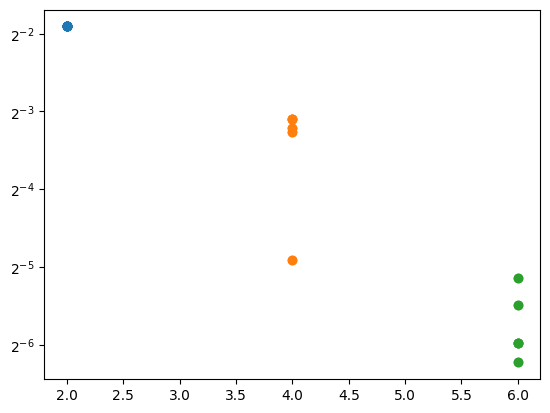

In [24]:
results = exp.results

qubits = sorted(list(results.keys()))
for num_qubits in qubits:
    num_layers = list(results[num_qubits].keys())[0]
    rates = results[num_qubits][num_layers]['rates']
    plt.scatter([num_qubits]*len(rates), rates)

plt.yscale('log', base=2)

In [ ]:
def _plot_results(results):
    # Assumes there is onle one `num_layers` per circuit size.
    qubits = sorted(list(results.keys()))
    for num_qubits in qubits:
        plt.scatter([num_qubits], results[num_qubits][0]['rate'])

In [5]:
exp

In [4]:
np.array(exp.results[8][50]['rates']).mean()

0.006797508047508047

In [ ]:
ExactMinExperiment.single_run()

In [61]:
num_qubits = 8
num_layers = 500

vqa = LocalVQA(num_qubits, num_layers)
observables = all_one_body_pauli(num_qubits)+all_two_body_pauli(num_qubits)

In [62]:
num_test_clifford_points = max(10, 10 * int(2 ** num_qubits / len(observables)))
rng = np.random.default_rng(41)
fixed_paulis, x, i_fixed = ExactMinExperiment.propose_exact_minimum(vqa, observables, num_test_clifford_points, rng)


 >>>>>>>>>>compiling<<<<<<<<<<
paulis ['IYYIIIII'], len(i_fixed) 3878(8016)
paulis ['IYYIIIII', 'IIIIIZXI'], len(i_fixed) 5867(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII'], len(i_fixed) 6884(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII', 'IIIIIIIX'], len(i_fixed) 7437(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII', 'IIIIIIIX', 'YIIZIIII'], len(i_fixed) 7702(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII', 'IIIIIIIX', 'YIIZIIII', 'IIYIIIII'], len(i_fixed) 7870(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII', 'IIIIIIIX', 'YIIZIIII', 'IIYIIIII', 'YIIIIIXI'], len(i_fixed) 7933(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII', 'IIIIIIIX', 'YIIZIIII', 'IIYIIIII', 'YIIIIIXI', 'IIIIYIXI'], len(i_fixed) 7933(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII', 'IIIIIIIX', 'YIIZIIII', 'IIYIIIII', 'YIIIIIXI', 'IIIIYIXI', 'IIIZIZII'], len(i_fixed) 7933(8016)
paulis ['IYYIIIII', 'IIIIIZXI', 'IIIZYIII', 'IIIIIIIX', 'YIIZIIII', 'IIYIIIII', 'YIIIIIXI', 'IIIIYIXI', 'IIIZIZII', 'IYIIIIIX'], le

In [63]:
vqa.expval(fixed_paulis)(x)

Array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.], dtype=float64)

In [64]:
remaining_observables = list(set(observables)-set(fixed_paulis))
vals = vqa.expval(remaining_observables)(x)
np.count_nonzero(vals>1e-5), np.count_nonzero(vals>1e-5)/vals.size

(16, 0.0625)

In [60]:
2**-8

0.00390625

In [26]:
1/0.0625

16.0

In [17]:
fixed_paulis, [remaining_observables[i] for i in np.where(vals > 1e-5)[0]]

(['IIYIII',
  'IIYIIX',
  'IIIYXI',
  'IXIIII',
  'YIIIII',
  'IXIIIX',
  'IXIYII',
  'IIYYII',
  'YIIIIX',
  'IIIIXX',
  'IIIIXI',
  'YIIYII'],
 ['IIYIXI',
  'YIYIII',
  'IIIIIX',
  'YXIIII',
  'IXIIXI',
  'IXYIII',
  'YIIIXI',
  'IIIYII',
  'IIIYIX'])

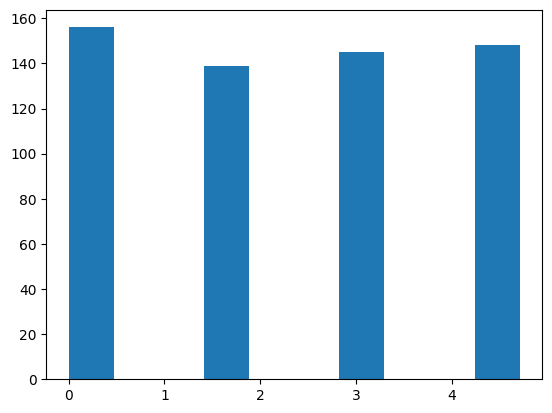

In [18]:
plt.hist(x[i_fixed]);

In [168]:
2**-num_qubits

0.00390625

In [146]:
y = rng.uniform(size=vqa.num_parameters)
y[i_fixed] = x[i_fixed]
vqa.expval([remaining_observables[i] for i in np.where(vals > 1e-5)[0]])(y)

Array([1., 1., 1.], dtype=float64)

In [147]:
num_grads = 100
num_uniform_samples = 10

x_rnd = vqa.random_parameters(num_uniform_samples)
x_rnd[:, i_fixed] = x[i_fixed]

shifts = np.pi / 2 * np.eye(vqa.num_parameters)
shifts = shifts[i_fixed]

random_subset = rng.choice(np.arange(len(shifts)), size=num_grads, replace=False)
shifts = shifts[random_subset]

x_shift = x_rnd.reshape(num_uniform_samples, 1, vqa.num_parameters) + shifts
x_shift_ = x_rnd.reshape(num_uniform_samples, 1, vqa.num_parameters) - shifts

In [151]:
vals_shift = jax.vmap(jax.vmap(vqa.expval(observables[:1])))(x_shift)
vals_shift_ = jax.vmap(jax.vmap(vqa.expval(observables[:1])))(x_shift_)
grad_shift = (vals_shift - vals_shift_) / 2

In [152]:
grad_shift.shape

(10, 100, 1)

In [159]:
import jax.numpy as jnp
def rexpval(x):
    return jnp.real(vqa.expval(observables[:1])(x))

In [162]:
vqa.expval(observables[:2])(x)

Array([1.11022302e-16, 1.80411242e-16], dtype=float64)

In [160]:
jax.vmap(jax.grad(rexpval))(x_rnd)


 >>>>>>>>>>compiling<<<<<<<<<<


DifferentiableCompileError: Catalyst.grad/jacobian only supports differentiation on floating-point results, got 'complex128' at position 0.

In [ ]:
jax.vmap(vqa.expval(fixed_paulis))

In [4]:
2**-8

0.00390625

In [2]:
exp = ExactMinExperiment('test')

qubits = (6, )
layers = (50,   )

exp.run(qubits, layers, num_samples_per_circuit=5)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


 Looking for exact minimum

 >>>>>>>>>>compiling<<<<<<<<<<

 Computing rates

 >>>>>>>>>>compiling<<<<<<<<<<
rate 1.0, values rate 0.0, vars rate 1.0, vars (values) rate 1.0

 Looking for exact minimum

 Computing rates
rate 1.0, values rate 0.0, vars rate 1.0, vars (values) rate 1.0

 Looking for exact minimum

 Computing rates
rate 1.0, values rate 0.0, vars rate 1.0, vars (values) rate 1.0

 Looking for exact minimum

 Computing rates
rate 1.0, values rate 0.0, vars rate 1.0, vars (values) rate 1.0

 Looking for exact minimum

 Computing rates
rate 1.0, values rate 0.0, vars rate 1.0, vars (values) rate 1.0


In [ ]:
exp = ExactMinExperiment('test')

qubits = (8, )
layers = (100,   )

exp.run(qubits, layers, num_samples_per_circuit=10)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


 Looking for exact minimum

 >>>>>>>>>>compiling<<<<<<<<<<

 >>>>>>>>>>compiling<<<<<<<<<<
paulis ['XIIIXIII'], len(i_fixed) 785(1616)
paulis ['XIIIXIII', 'IIIZIIZI'], len(i_fixed) 1200(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII'], len(i_fixed) 1405(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII', 'IIXIIIIX'], len(i_fixed) 1481(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII', 'IIXIIIIX', 'IIXIIZII'], len(i_fixed) 1527(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII', 'IIXIIIIX', 'IIXIIZII', 'ZIIIZIII'], len(i_fixed) 1556(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII', 'IIXIIIIX', 'IIXIIZII', 'ZIIIZIII', 'IZXIIIII'], len(i_fixed) 1583(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII', 'IIXIIIIX', 'IIXIIZII', 'ZIIIZIII', 'IZXIIIII', 'IIXIIIZI'], len(i_fixed) 1583(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII', 'IIXIIIIX', 'IIXIIZII', 'ZIIIZIII', 'IZXIIIII', 'IIXIIIZI', 'IIIZIZII'], len(i_fixed) 1583(1616)
paulis ['XIIIXIII', 'IIIZIIZI', 'IZIZIIII', 'IIXIIIIX', 'IIXIIZII', 'ZII

In [1]:
2**14

16384

In [4]:
2**-6

0.015625

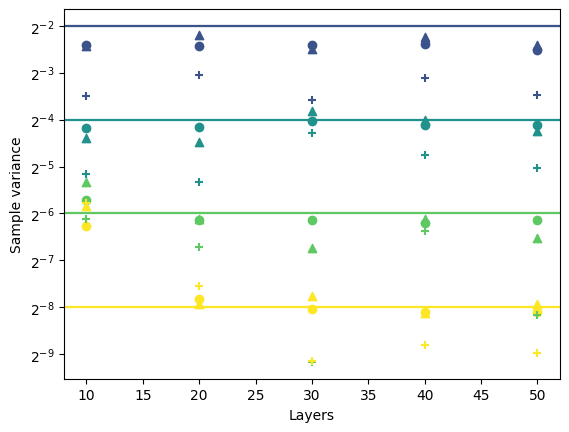

In [2]:
bp_experiment = BPExperiment.load('main')

qubits = (8, 10)
layers = range(10, 50+1, 10)
num_paulis = 30
num_samples = 30

# bp_experiment.run(qubits, layers, num_paulis, num_samples)
bp_experiment.plot_results()

In [3]:
2**-10

0.0009765625

In [4]:
num_qubits = 10
num_layers = 50

vqa = LocalVQA(num_qubits, num_layers)

In [5]:
observables = all_local_two_body_pauli(num_qubits)
x = vqa.random_clifford_parameters(num_samples=100)

obs = all_local_two_body_pauli(num_qubits) * int(2**num_qubits / len(all_local_two_body_pauli(num_qubits)))

In [6]:
jax.vmap(vqa.expval(obs[:1]))(x[:1])


 >>>>>>>>>>compiling<<<<<<<<<<


TypeError: ModuleContext.__init__() got an unexpected keyword argument 'name_stack'

In [ ]:
%%timeit
jax.vmap(vqa.expval(obs))(x[:1])

In [1]:
%%time
jax.vmap(vqa.expval(obs))(x[:1])

NameError: name 'jax' is not defined

In [2]:
%%time
jax.vmap(vqa.expval(obs))(x[:10])

NameError: name 'jax' is not defined

# Exact min experiments

In [2]:
exp= ExactMinExperiment.load('main')
exp.results

defaultdict(functools.partial(<class 'collections.defaultdict'>, functools.partial(<class 'collections.defaultdict'>, <class 'list'>)),
            {2: defaultdict(functools.partial(<class 'collections.defaultdict'>, <class 'list'>),
                         {100: defaultdict(list,
                                      {'paulis': [['YY', 'ZZ', 'XX'],
                                        ['ZX', 'YY'],
                                        ['XY', 'ZZ'],
                                        ['YY', 'XZ'],
                                        ['XZ', 'YY'],
                                        ['XY', 'ZX', 'YZ'],
                                        ['ZY', 'XZ', 'YX'],
                                        ['YY', 'XX', 'ZZ'],
                                        ['ZZ', 'XY'],
                                        ['ZY', 'XX']],
                                       'rates': [0.3225806451612903,
                                        0.3271889400921659,
             

In [22]:
exp_exact = ExactMinExperiment.load('new_test')
exp_exact.results[8][400]

defaultdict(list,
            {'paulis': [['IXIIIIIY',
               'IIIIIZIY',
               'IXIXIIII',
               'XIZIIIII',
               'IIZIIZII',
               'IIIXIZII',
               'IIIIIZXI',
               'IXZIIIII',
               'XIIIIIIY',
               'XIIIZIII',
               'IXIIZIII',
               'IXIIIIXI',
               'XIIXIIII',
               'XIIIIIXI',
               'IIIIZZII'],
              ['XIIIIYII',
               'IIIIIIYX',
               'XIIXIIII',
               'IIIIIIXZ',
               'IZIIXIII',
               'IIXIXIII',
               'IIIIIIZY',
               'IZIXIIII',
               'IIXXIIII',
               'IZIIIYII',
               'IIXIIYII',
               'XIIIXIII'],
              [],
              ['XXIIIIII',
               'IIIIXXII',
               'IIIIXIYI',
               'IIIYIIYI',
               'IIIIXIIY',
               'IIIYIIIY',
               'ZYIIIIII',
               'IIIYIXII',
       

In [ ]:
qubits = (10,)
layers = (60, )

num_samples_per_circuit = 10
num_test_clifford_points = 10
num_test_uniform_points = 10
max_grads = 20
max_obs = 20

exp_exact.run(
    qubits, 
    layers, 
    num_samples_per_circuit, 
    num_test_clifford_points, 
    num_test_uniform_points,
    max_grads,
    max_obs,
    seed=42)


 Starting, muhaha!


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


 I"m gonna _RUN this!

 Looking for exact minimum


In [8]:
exp_exact.results

defaultdict(functools.partial(<class 'collections.defaultdict'>, functools.partial(<class 'collections.defaultdict'>, <class 'list'>)),
            {4: defaultdict(functools.partial(<class 'collections.defaultdict'>, <class 'list'>),
                         {10: defaultdict(list,
                                      {'paulis': [['IZZI',
                                         'YIZI',
                                         'IZIY',
                                         'YIIY'],
                                        ['IYZI',
                                         'XIIZ',
                                         'YIIY',
                                         'IXYI',
                                         'IZXI'],
                                        ['IYIY', 'ZIXI', 'ZIIY', 'IYXI'],
                                        ['XIIX', 'XIZI', 'IZIX', 'IZZI'],
                                        ['IIYZ', 'ZXII', 'IXYI', 'ZIIZ'],
                                        ['X

# BP experiments

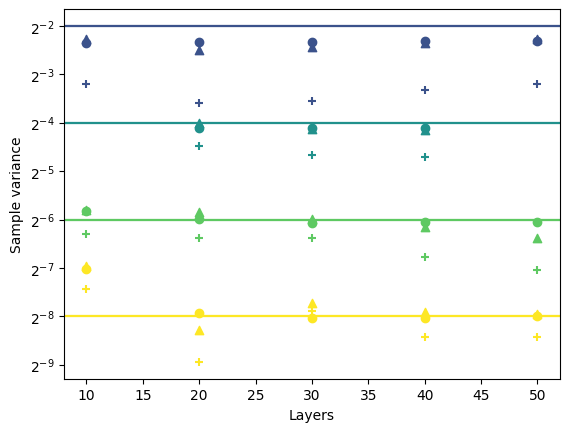

In [6]:
exp1 = BPExperiment.load('test1')

# qubits = range(2, 8+1, 2)
# layers = range(10, 50+1, 10)
# num_samples = 100

exp1.plot_results()


# Exact minimums

In [13]:
'10'

TypeError: sequence item 0: expected str instance, int found

In [7]:
a1 = list(range(10))
a2 = a1

a1, a2

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
def print_k(k):
    for k in range(10):
        k
    
    return k

In [8]:
a2 = list(set(a2) - {1, 2, 3, 15})
a1, a2

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 4, 5, 6, 7, 8, 9])

In [2]:
num_qubits = 10
num_layers = 10
vqa = LocalVQA(num_qubits, num_layers)
rng = np.random.default_rng(42)

x = np.zeros(vqa.num_parameters)
i_fixed = np.array([], dtype=int)
paulis = all_two_body_pauli(num_qubits)

nonzero_paulis = []
while True:
    iteration_successful, pauli, x = find_nonzero_pauli(vqa, paulis, x, i_fixed, rng, num_samples=100)
    
    if not iteration_successful:
        break

    new_fixed = find_indices_of_fixed_angles(vqa, pauli, x)
    i_fixed = np.unique(np.concatenate([i_fixed, new_fixed]))

    paulis.remove(pauli)
    nonzero_paulis.append(pauli)
    
    print(nonzero_paulis, len(i_fixed), vqa.num_parameters)

NameError: name 'LocalVQA' is not defined

In [30]:
vqa= LocalVQA(2, 0)
paulis = ['II', 'ZZ']

print(vqa.qiskit_circuit.draw())
print(vqa._flat_params)

     ┌────────┐┌────────┐
q_0: ┤ Rx(x0) ├┤ Rz(z0) ├
     ├────────┤├────────┤
q_1: ┤ Rx(x1) ├┤ Rz(z1) ├
     └────────┘└────────┘
[Parameter(x0), Parameter(x1), Parameter(z0), Parameter(z1)]


In [25]:
np.vstack([vec, m])

array([[0.        , 1.        , 2.        , 4.        ],
       [0.15184883, 0.54025631, 0.85841882, 0.71945407],
       [0.54526043, 0.18605528, 0.28902469, 0.05481335],
       [0.54907367, 0.59640534, 0.95748073, 0.11858887]])

In [ ]:
y = vqa.random_parameters(num_samples=131, rng=131)
y[:, i_fixed] = x[i_fixed]
values = vqa.expval_vmap(paulis, y)

In [3]:
paulis_fixed = []
for i in range(len(paulis)):
    if not np.allclose(values[:, i], 0) and np.allclose(values[:, i], 1):
        paulis_fixed.append(paulis[i])

NameError: name 'paulis' is not defined

In [ ]:
len(paulis_fixed) / len(paulis), 2**-num_qubits

In [4]:
np.abs(values).mean(axis=0)

NameError: name 'np' is not defined

observables = all_local_two_body_pauli(num_qubits)

num_samples = 300
seed = 41

uniform_variances = vqa.uniform_variance(observables, num_samples=num_samples, rng=seed)
clifford_variances = vqa.clifford_variance(observables, num_samples=num_samples, rng=seed)
print('expected', 2**-num_qubits)
print(f'uniform var: {uniform_variances.mean()} std: {uniform_variances.std()}')
print(f'clifford var: {clifford_variances.mean()} std: {clifford_variances.std()}')

# Shallowing

In [5]:
exp = ShallowingExperiment('95')
schedule = [0.95, 0.96, 0.97, 0.98, 0.99]
num_qubits = 4
num_layers = 50
num_clifford = 5
num_samples = 50
exp.run(num_qubits, num_layers, num_clifford, num_samples, schedule)

NameError: name 'ShallowingExperiment' is not defined

In [6]:
exp.plot_results()
plt.yscale('log')

NameError: name 'exp' is not defined

In [7]:
shexperiment = ShallowingExperiment.load('shtest')

NameError: name 'ShallowingExperiment' is not defined

In [8]:
num_qubits = 6
num_layers = 100
shexperiment.run(num_qubits, num_layers, 5, 50)

NameError: name 'shexperiment' is not defined

In [9]:
shexperiment.plot_results()
plt.yscale('log')

NameError: name 'shexperiment' is not defined

In [10]:
uniform_bp_exp = UniformBPExperiement.load('uniform_test')


NameError: name 'UniformBPExperiement' is not defined

In [11]:
uniform_bp_exp = UniformBPExperiement.load('uniform_test')
uniform_bp_exp.run([8], range(10, 50+1, 10), 10)

NameError: name 'UniformBPExperiement' is not defined

# Uniform BP

In [12]:
uniform_bp_exp.plot_results()

NameError: name 'uniform_bp_exp' is not defined

In [13]:
uniform_bp_exp.results[2][10].mean()

NameError: name 'uniform_bp_exp' is not defined

In [14]:
uniform_bp_exp.save()

NameError: name 'uniform_bp_exp' is not defined

In [15]:
UniformBPExperiement.load(uniform_bp_exp.name)

NameError: name 'UniformBPExperiement' is not defined